### Searching the ChEMBL Database for Interesting SAR 
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_posts/refs/heads/main/chembl_herg/sherlock_robot.png" width=300/>

This analysis stems from a conversation I had with some friends working on the [OpenADMET](https://openadmet.org/) project. One of the aims of OpenADMET is to solve structures of ligands bound to off-targets like hERG, an ion channel that has been implicated in cardiac liabilities. I thought it would be interesting to find cases in the medicinal chemistry literature where a hERG liability had been mitigated. We would have a pair of similar compounds, one of which binds to hERG and the other that doesn't. If we obtain a cryoEM structure of the hERG binder, can we use the structure to rationalize the lack of hERG activity in the inactive analog? To this end, I wanted to search ChEMBL to find cases where a team had resolved a hERG liability. To do this, I performed a search to identify pairs of similar compounds from the same paper where the hERG activity differed by at least 10-fold. This notebook details the steps I took in this process. 

If in Google Colab download and unzip the ChEMBL database.  This takes about 3.5 minutes. 

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !wget https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_mysql.tar.gz
    !gunzip chembl_35_mysql.tar.gz

Load the necessary Python libraries

In [2]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import useful_rdkit_utils as uru
from itertools import combinations
import numpy as np
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem import PandasTools
from molbloom import buy
from tqdm.auto import tqdm

To begin, we know that the Uniprot ID for hERG is Q12809. To search ChEMBL for compounds tested against hERG, we need to convert that Uniprot ID to a ChEMBL ID. There is a file called `chembl_unitprot_mapping.txt` available on the ChEMBL download site that maps ChEMBL IDs to Uniprot IDs. Let's load that file into a Pandas DataFrame so we can search it.

In [3]:
df = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_uniprot_mapping.txt",sep="\t",
                comment='#',
                names=['uniprot_id','chembl_id','target_name','target_type'])

Now we'll search the dataframe for that Uniprot id. 

In [4]:
df.query("uniprot_id  == 'Q12809' and target_type == 'SINGLE PROTEIN'")

,uniprot_id,chembl_id,target_name,target_type
419,Q12809,CHEMBL240,HERG,SINGLE PROTEIN


Create a connection to the ChEMBL database.  If you're running this notebook locally, change the location of the sqlite database file. 

In [5]:
if IN_COLAB:
    path = "./chembl_35.db"
else:
    path =  "/Users/pwalters/.data/chembl/35/chembl_35/chembl_35_sqlite/chembl_35.db"

In [6]:
conn = sqlite3.connect(path)
cursor = conn.cursor()

Here's the sql query to grab all the hERG data and surrounding information from ChEMBL.  

- **target_dictionary**: Filters targets by chembl_id (CHEMBL240).
- **assays**: Links targets (tid) to assays (assay_id).
- **docs**: Provides document details (doc_id, doi, title).
- **activities**: Connects assays to compound records and provides standard_value and standard_units.
- **compound_records**: Links compound records to molecular structures and provides compound_id.
- **compound_structures**: Extracts canonical_smiles.

In [7]:
sql = """SELECT
    d.doc_id,
    d.doi,
    d.title,
    a.assay_id,
    cr.compound_key,
    cs.canonical_smiles,
    act.standard_type,
    act.standard_value,
    act.standard_relation,
    act.standard_units,
    act.pchembl_value
FROM
    target_dictionary td
        JOIN
    assays a ON td.tid = a.tid
        JOIN
    docs d ON a.doc_id = d.doc_id
        JOIN
    activities act ON a.assay_id = act.assay_id AND d.doc_id = act.doc_id
        JOIN
    compound_records cr ON act.record_id = cr.record_id
        JOIN
    compound_structures cs ON cr.molregno = cs.molregno
WHERE
    td.chembl_id = 'CHEMBL240';"""

Run the query

In [8]:
res = cursor.execute(sql)

Load the results into a Pandas dataframe

In [9]:
df = pd.read_sql_query(sql,conn)

In [10]:
df

,doc_id,doi,title,assay_id,compound_key,canonical_smiles,standard_type,standard_value,standard_relation,standard_units,pchembl_value
0,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5f,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCN(C(C)C)C...,Ki,1200.0,=,nM,5.92
1,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5i,CC(C(=O)NC1(c2ccccc2)CCC(N2CCC3(CCCO3)CC2)CC1)...,Ki,730.0,=,nM,6.14
2,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,2,CC(C(=O)N[C@]1(c2ccccc2)CC[C@@H](N2CCC(c3ccc(F...,Ki,43.0,=,nM,7.37
3,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5b,CC(C(=O)N[C@]1(c2ccccc2)CC[C@H](N2CCCCC2)CC1)c...,Ki,1200.0,=,nM,5.92
4,4905,10.1016/s0960-894x(02)00250-0,"4,4-Disubstituted cyclohexylamine NK(1) recept...",220871,5c,CC1CCN([C@H]2CC[C@](NC(=O)C(C)c3cc(C(F)(F)F)cc...,Ki,460.0,=,nM,6.34
...,...,...,...,...,...,...,...,...,...,...,...
30462,128726,10.6019/CHEMBL5465560,Selectivity Literature for EUbOPEN Chemogenomi...,2415487,EUB0000223bCl,COc1cc(C(=O)N2CC[C@@H](O)[C@@H](N)C2)cc2nc(-c3...,pXC50,4.5,=,M,NaN
30463,128726,10.6019/CHEMBL5465560,Selectivity Literature for EUbOPEN Chemogenomi...,2415668,EUB0000271b,Cc1cc(C)cc([C@@H]2c3cc(C)ccc3NC(=O)CN2C(=O)c2c...,% of inhibition,0.0,=,%,NaN
30464,128726,10.6019/CHEMBL5465560,Selectivity Literature for EUbOPEN Chemogenomi...,2417028,EUB0000279b,CC(=O)c1cc(-c2ccccc2OCC2CC2)c2ncccn12,% of control,111.0,=,%,NaN
30465,128726,10.6019/CHEMBL5465560,Selectivity Literature for EUbOPEN Chemogenomi...,2417816,EUB0000041b,Cc1cccc(-c2[nH]c(CNc3ccccc3F)nc2-c2ccc3ncnn3c2)n1,IC50,31040.0,=,nM,4.51


Only keep compounds with measured values that don't have an operator (>,<) and have standard units in nM (skip entries with %)

In [11]:
df_ok = df.dropna(subset="pchembl_value").query("standard_relation == '='").query("standard_units == 'nM'").copy()

In [12]:
tqdm.pandas()

Calculate fingerprints 

In [13]:
smi2fp = uru.Smi2Fp()
df_ok['fp'] = df_ok.canonical_smiles.progress_apply(smi2fp.get_fp)

  0%|          | 0/11830 [00:00<?, ?it/s]

A function to process the structures from a paper and identify interesting pairs of compounds where the hERG activity differs by at least 10-fold. The logic here is as follows.  
1. Group the data by **assay id** and **result type** (IC50 or Ki)
2. Loop over pairs of compounds
3. Select pairs where the difference in activity is at least 10-fold
4. Calculate the Tanimoto similarity between pairs
5. Store the pair 

In [14]:
def process_paper(paper_df):
    res = []
    for k,v in paper_df.groupby(["assay_id","standard_type"]):
        for a,b in combinations(list(v.iterrows()),2):
            idx_a, vals_a = a
            idx_b, vals_b = b
            delta = np.abs(vals_a.pchembl_value-vals_b.pchembl_value)
            if delta > 1:
                if vals_a.standard_value > vals_b.standard_value:
                    vals_a, vals_b = vals_b, vals_a
                tc = DataStructs.TanimotoSimilarity(vals_a.fp,vals_b.fp)
                res.append([vals_a.doc_id, vals_a.doi,
                      delta,tc,vals_a.standard_type,
                      vals_a.canonical_smiles,vals_b.canonical_smiles,
                      vals_a.compound_key, vals_b.compound_key,
                      vals_a.standard_value,vals_b.standard_value])
    cols = ["doc_id", "doi", "delta", "tanimoto","standard_type","smiles_a","smiles_b","key_a","key_b","val_a","val_b"]
    res_df = pd.DataFrame(res, columns=cols)
    return res_df

Process papers one at a time.  Each call to `process_paper` returns a dataframe with "interesting" pairs. In the cell below, we build up a list of these dataframes.  

In [15]:
df_list = []
for k,v in tqdm(df_ok.groupby("doc_id")):
    res_df = process_paper(v)
    if len(res_df):
        df_list.append(res_df)

  0%|          | 0/1576 [00:00<?, ?it/s]

Concatenate the list of dataframes from the cell above into a single dataframe. 

In [16]:
combo_df = pd.concat(df_list)

See how many papers contained interesting pairs

In [17]:
len(df_list)

532

See how many structure pairs we extracted. 

In [18]:
len(combo_df)

69800

Create a new dataframe with only IC50 and Ki data.

In [19]:
ic50_ki_df = combo_df.query("standard_type in ['IC50','Ki']").copy()

How many documents are left? 

In [20]:
len(ic50_ki_df.doc_id.unique())

526

Use [Andrew White's molbloom filter](https://github.com/whitead/molbloom) to determine whether compounds are commercially available. 

In [21]:
ic50_ki_df['buy_a'] = ic50_ki_df.smiles_a.apply(buy)
ic50_ki_df['buy_b'] = ic50_ki_df.smiles_b.apply(buy)

Create a new dataframe containing pairs where both molecules are commercially available. 

In [22]:
buy_df = ic50_ki_df.query("buy_a and buy_b and tanimoto >= 0.5").copy()

In [23]:
PandasTools.AddMoleculeColumnToFrame(buy_df,smilesCol="smiles_a",molCol="mol_a")
PandasTools.AddMoleculeColumnToFrame(buy_df,smilesCol="smiles_b",molCol="mol_b")

In [24]:
def make_clickable_url(val):
    val = "https://doi.org/"+val
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

In [25]:
def mcs_align_mol_pair(mol1, mol2):
    params = Chem.rdFMCS.MCSParameters()
    params.BondCompareParameters.CompleteRingsOnly=True
    params.AtomCompareParameters.CompleteRingsOnly=True
    # find the MCS
    mcs = FindMCS([mol1,mol2],params)
    # get query molecule from the MCS, we will use this as a template for alignment
    qmol = mcs.queryMol
    # generate coordinates for the template
    AllChem.Compute2DCoords(qmol)
    # generate coordinates for the molecules using the template
    [AllChem.GenerateDepictionMatching2DStructure(m,qmol) for m in [mol1,mol2]]

In [26]:
for a,b in tqdm(buy_df[["mol_a","mol_b"]].values):
    mcs_align_mol_pair(a,b)

  0%|          | 0/22 [00:00<?, ?it/s]

Scroll right to see the chemical structures

,doc_id,doi,delta,tanimoto,standard_type,smiles_a,smiles_b,key_a,key_b,val_a,val_b,buy_a,buy_b,mol_a,mol_b
236,5535,10.1016/s0960-894x(03)00196-3,1.83,0.583333,IC50,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,Fc1ccc(-n2cc(C3CCNCC3)c3cc(Cl)ccc32)cc1,Sertindole,14,3.000,204.00,True,True,,
169,5706,10.1016/s0960-894x(03)00492-x,1.45,0.602273,IC50,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,Desmetheylastemizole,Norastemizole,1.000,28.18,True,True,,
646,5706,10.1016/s0960-894x(03)00492-x,1.14,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,Clozapine,Norclozapine,323.590,4466.84,True,True,,
23,20904,10.1016/j.bmcl.2005.01.008,1.49,0.582418,IC50,COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2...,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,Astemizole,Norastemizole,0.912,28.18,True,True,,
88,42094,10.1016/j.bmc.2008.04.028,1.45,0.602273,IC50,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,"58, Desmethylastemizole","65, Norastemizole",1.000,28.18,True,True,,
635,42094,10.1016/j.bmc.2008.04.028,1.14,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,14,"41, Norclozapine",323.590,4466.84,True,True,,
31,44897,10.1016/j.bmcl.2008.10.028,1.06,0.517241,IC50,CNCc1ccc(Cl)cc1Oc1ccc(Cl)cc1,CNCc1cc(F)ccc1Oc1ccc(Cl)cc1,54,24,645.000,7390.00,True,True,,
7,46532,10.1016/j.ejmech.2007.12.025,1.44,0.602273,IC50,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,Fc1ccc(Cn2c(NC3CCNCC3)nc3ccccc32)cc1,Desmethylastemizole,Norastemizole,1.000,27.54,True,True,,
465,46990,10.1021/jm900002x,1.15,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,Clozapine,N-desmethyl-Clozapine,320.000,4490.00,True,True,,
501,46990,10.1021/jm900002x,1.15,0.735294,IC50,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2,Clozapine,N-desmethyl-Clozapine,320.000,4490.00,True,True,,

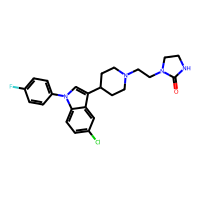
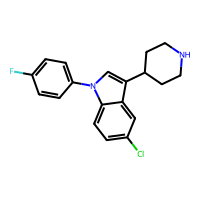
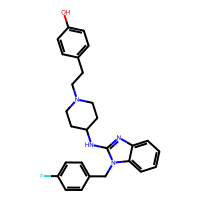
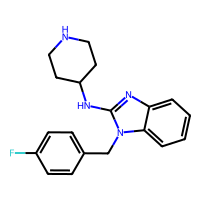
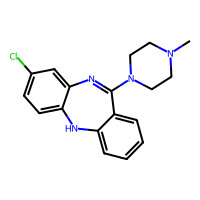
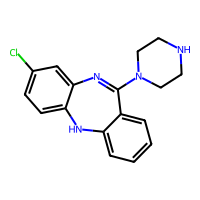
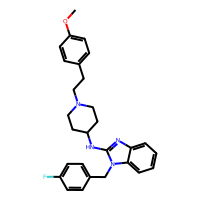
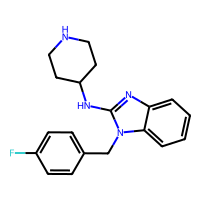
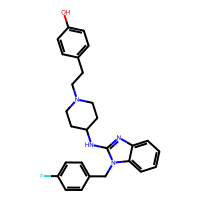
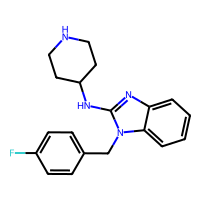
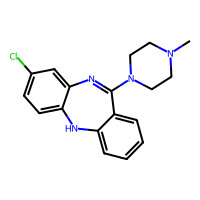
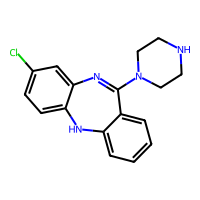
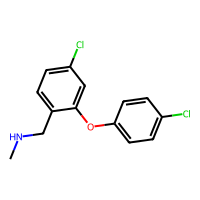
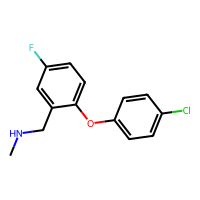
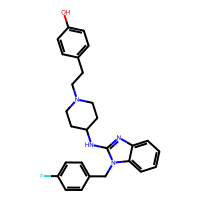
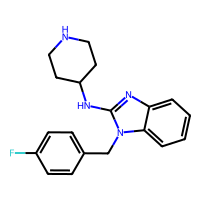
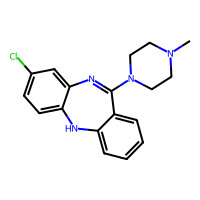
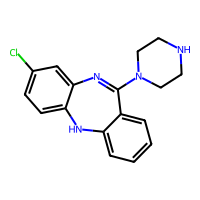
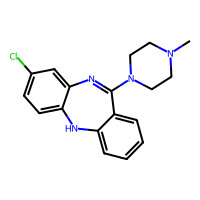
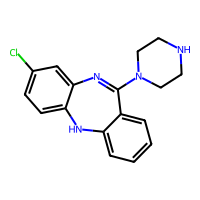
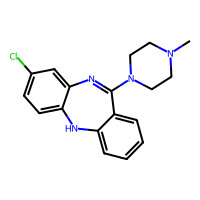
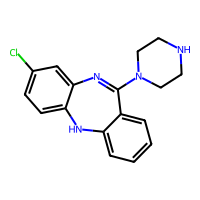
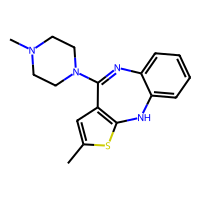
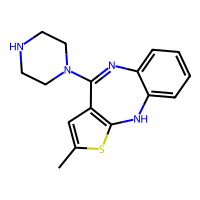
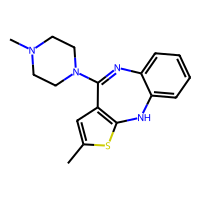
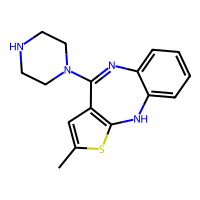
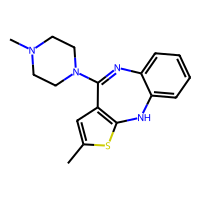
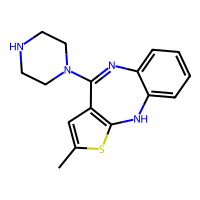
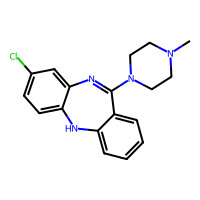
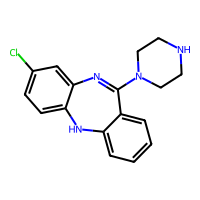
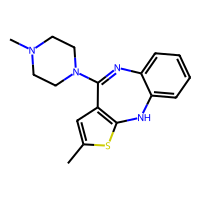
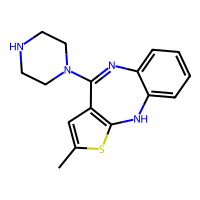
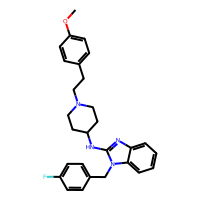
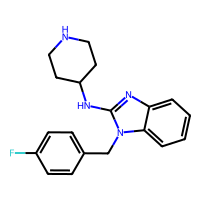
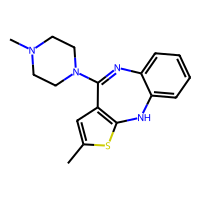
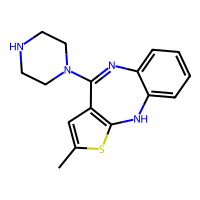
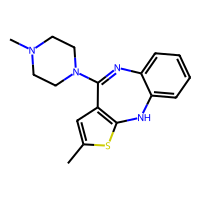
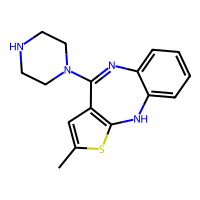
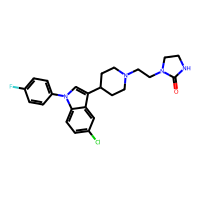
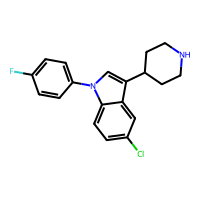
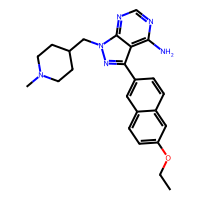
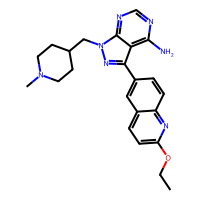
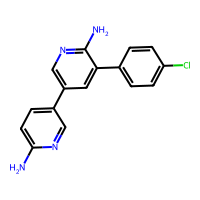
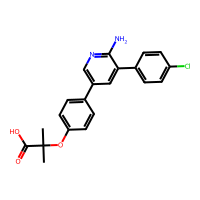

In [27]:
buy_df